In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import os
import sys
import datetime
import time
sys.path.append('/data/code/finhack')
from library.backtest import bt
import traceback
from library.mydb import mydb
import hashlib
from concurrent.futures import ThreadPoolExecutor,ProcessPoolExecutor, wait, ALL_COMPLETED
from library.astock import AStock
import json
from factors.factorAnalyzer import factorAnalyzer
from factors.factorManager import factorManager
from factors.alphaEngine import alphaEngine
import factors.alphaEngine as alphaFunc

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import time



#判断并自动加载中文字体
#print(matplotlib.matplotlib_fname())
if not os.path.exists("/usr/share/fonts/SimHei.ttf"):
    print("没有发现中文字体，尝试下载...")
    os.system("wget -q https://us-logger1.oss-cn-beijing.aliyuncs.com/SimHei.ttf -O /usr/share/fonts/SimHei.ttf")
    while not os.path.exists("/usr/share/fonts/SimHei.ttf"):
        time.sleep(1)
    os.system("rm -rf ~/.cache/matplotlib")
    print("下载完毕，请点击上方菜单“内核-重启” 进行加载！")


matplotlib.rcParams['font.family'] = ['sans-serif'] #用simhei 字体显示中文
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] #用simhei 字体显示中文
matplotlib.rcParams['axes.unicode_minus'] = False #这个用来正常显示负号



In [3]:
def getFundList():
    sql_list="SELECT DISTINCT ts_code,`name`  FROM `tushare`.`fund_basic` where  fund_type='股票型'  and status='L'   order by name asc  "
    fund_list=mydb.selectToDf(sql_list,'tushare')
    return fund_list

def getETFList():
    #sql_etf_list="SELECT DISTINCT ts_code,`name`  FROM `tushare`.`fund_basic` where name like '%ETF' and fund_type='股票型' and not name like '%纳指%'  and not name like '%0%'  and not name like '%货币%' and not name like '%龙头%'  and status='L'   order by name asc  LIMIT 0,1000"
    sql_etf_list="SELECT DISTINCT ts_code,`name`  FROM `tushare`.`fund_basic` where name like '%ETF' and fund_type='股票型'  and status='L'   order by name asc  "
    etf_list=mydb.selectToDf(sql_etf_list,'tushare')
    return etf_list



def getFundPrice(ts_code):
    #sql_fund_price="SELECT fund_daily.trade_date,close as price FROM `tushare`.`fund_daily`  where fund_daily.ts_code='%s'" % ts_code
    sql_fund_price="SELECT fund_daily.trade_date,close*adj_factor as price FROM `tushare`.`fund_daily` LEFT JOIN fund_adj on fund_daily.ts_code=fund_adj.ts_code  and fund_daily.trade_date=fund_adj.trade_date where fund_daily.ts_code='%s'" % ts_code
    fund_price=mydb.selectToDf(sql_fund_price,'tushare')
    if fund_price.empty:
        return fund_price
    fund_price['trade_date'] = pd.to_datetime(fund_price['trade_date'], format='%Y%m%d')
    return fund_price











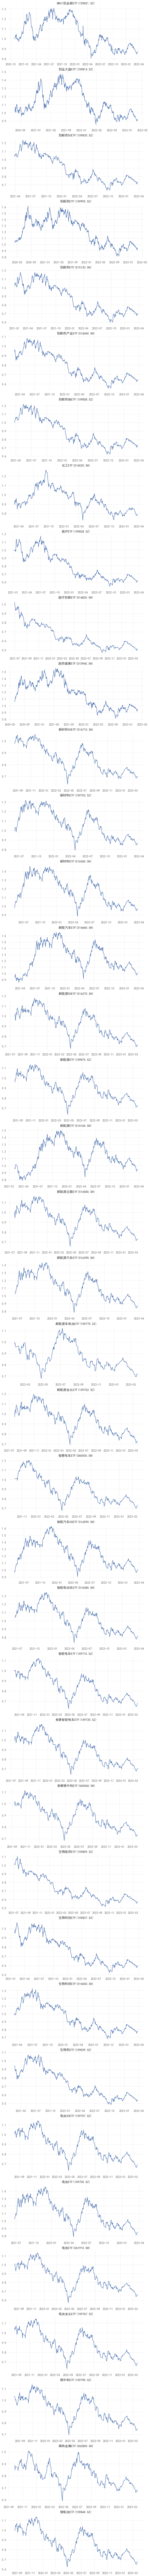

In [4]:
#低估值etf

etf_uv_list=[]#undervaluation

etf_list=getETFList()
for row in etf_list.itertuples():
    name=getattr(row,"name")
    ts_code=getattr(row,"ts_code")
    df_fund_price=getFundPrice(ts_code)
    if df_fund_price.empty:
        continue
    
    min=df_fund_price['price'].min()
    mean=df_fund_price['price'].mean()
    now=df_fund_price['price'].tail(1)
    diff_min=float(now)/float(min)
    diff_mean=float(mean)/float(now)
    if diff_min<1.2 and  diff_mean>1.2 and len(df_fund_price)>200:
        etf_uv_list.append({
            "ts_code":ts_code,
            "name":name,
            "price":df_fund_price
        })
    
    

if etf_uv_list!=[]:
    fig, ax = plt.subplots(len(etf_uv_list),1,figsize=(10,5*len(etf_uv_list)))
    i=0
    for uv in etf_uv_list:
        name=uv['name']
        ts_code=uv['ts_code']
        df_fund_price=uv['price']
        ax[i].plot(df_fund_price['trade_date'],df_fund_price['price'])
        ax[i].set_title("%s(%s)" % (name,ts_code))
        i=i+1
    
    plt.show()


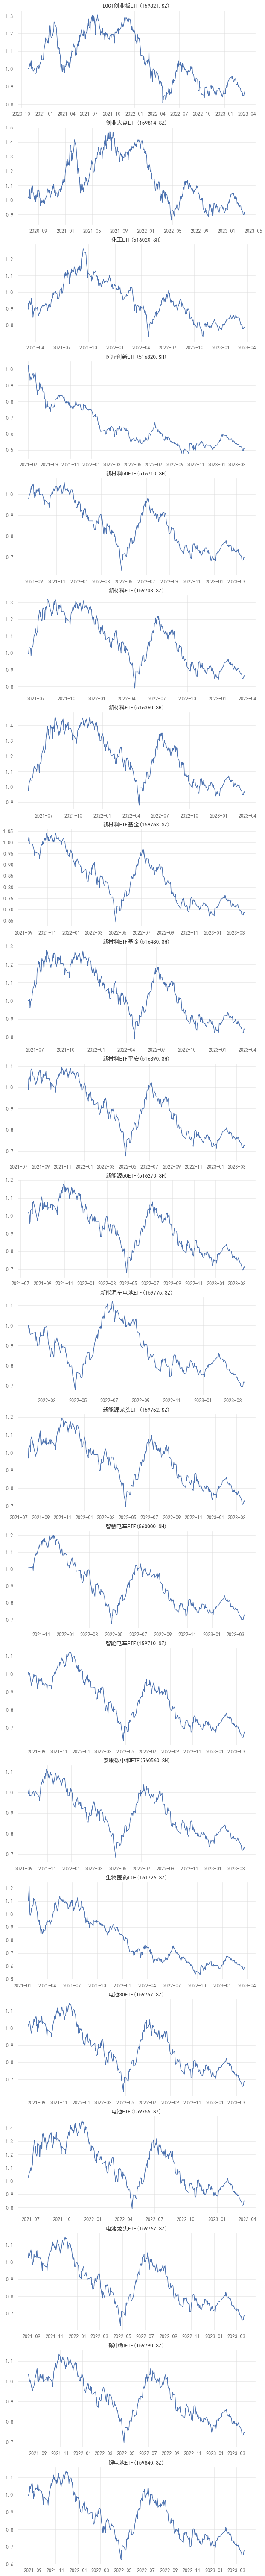

In [5]:
#低估值基金

uv_list=[]#undervaluation

fund_list=getFundList()
for row in fund_list.itertuples():
    name=getattr(row,"name")
    ts_code=getattr(row,"ts_code")
    df_fund_price=getFundPrice(ts_code)
    if df_fund_price.empty:
        continue
    
    min=df_fund_price['price'].min()
    mean=df_fund_price['price'].mean()
    now=df_fund_price['price'].tail(1)
    diff_min=float(now)/float(min)
    diff_mean=float(mean)/float(now)
    if diff_min<1.1 and  diff_mean>1.2 and len(df_fund_price)>200:
        uv_list.append({
            "ts_code":ts_code,
            "name":name,
            "price":df_fund_price
        })
    
    

if uv_list!=[]:
    fig, ax = plt.subplots(len(uv_list),1,figsize=(10,5*len(uv_list)))
    i=0
    for uv in uv_list:
        name=uv['name']
        ts_code=uv['ts_code']
        df_fund_price=uv['price']
        ax[i].plot(df_fund_price['trade_date'],df_fund_price['price'])
        ax[i].set_title("%s(%s)" % (name,ts_code))
        i=i+1
    
    plt.show()